In [37]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Define paths
images_path = 'data/Images'
captions_file = 'data/captions.txt'

In [5]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

In [6]:
# Example caption
captions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
# Preprocess captions and clean the text up
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption

# Surprisingly loops over all keys
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [8]:
# Define image transformation
transform = transforms.Compose([
    # CHANGE image size
    transforms.Resize((184, 184)),
    transforms.ToTensor(),
    # TODO: Update this part of the function
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

# Load image function helper
def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [9]:
# Build vocabulary
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [10]:
# Create dictionaries for words
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [11]:
# Add special tokens
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [12]:
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [13]:
# Calculate the max length of the cpations
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2
max_length

34

In [14]:
# Loops over all image keys, all caption lists, all captions in caption lists, encodes them, and pads them
encoded_captions = defaultdict(list)

for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)

In [15]:
# Function to create input and target sequences
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [16]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [17]:
# Creating randomized batches
image_keys = list(captions.keys())

In [18]:
torch.manual_seed(1337)

In [19]:
# Shuffle the dataset
shuffled_indices = torch.randperm(len(image_keys)).tolist()
image_keys = [image_keys[i] for i in shuffled_indices]

In [20]:
# Split the dataset (80% training, 20% validation)
split_index = int(0.8 * len(image_keys))
train_keys = image_keys[:split_index]
val_keys = image_keys[split_index:]

In [21]:
# Train and validation sets
train_captions = {key: captions[key] for key in train_keys}
val_captions = {key: captions[key] for key in val_keys}
train_input_sequences = {key: input_sequences[key] for key in train_keys}
val_input_sequences = {key: input_sequences[key] for key in val_keys}
train_target_sequences = {key: target_sequences[key] for key in train_keys}
val_target_sequences = {key: target_sequences[key] for key in val_keys}

In [22]:
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []
    
    selected_images = random.sample(list(caption_dict.keys()), batch_size)
    for image in selected_images:
        # Pick a random index from one of the caption lists
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        # Add the corresponding image caption
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        # Get the corresponding target_caption
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        # Add the image to the corresponding image to the image set
        images_batch.append(load_image(image))
    
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch


In [23]:
# Example usage:
batch_size = 4
images_batch, input_captions_batch, target_captions_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)


In [24]:
images_batch.shape

torch.Size([4, 3, 184, 184])

In [25]:
input_captions_batch.shape

torch.Size([4, 33])

In [26]:
target_captions_batch.shape

torch.Size([4, 33])

In [27]:
train_captions

{'2517284816_9b8fd3c6b6.jpg': ['crowd of children',
  'large crowd of girls are all wearing green skirts and white tank tops',
  'large group of young people all dressed in white tops and green bottoms',
  'boys and girls at party',
  'middle school aged kids are showing their school spirit at pep ralley'],
 '2602306033_2b3100d36b.jpg': ['black dog biting onto something is swimming in the beach',
  'black dog with stick swimming in the ocean',
  'dog with frisbee swimming in lake',
  'big black dog swimming in the ocean with something in his mouth',
  'dog swimming in the water with stick'],
 '3042380610_c5ea61eef8.jpg': ['group of people are standing around sound mixing table',
  'group of people looking at sound equipment',
  'people are inspecting sound equipment indoors',
  'people examine equipment',
  'six people standing behind electrical equipment'],
 '2698119128_62b4741043.jpg': ['girl enjoys the swimming pool',
  'young girl in an orange bathing suit is about to splash into p

Training example:


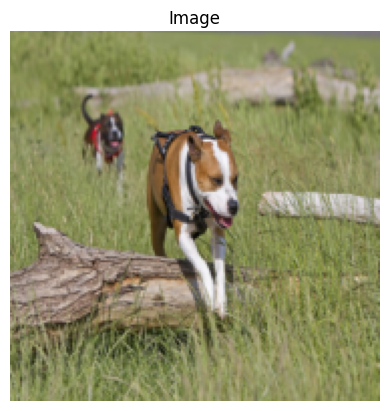

Input Caption: <START> brown and white dog is leaping over log in field while another dog follows behind it <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: brown and white dog is leaping over log in field while another dog follows behind it <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


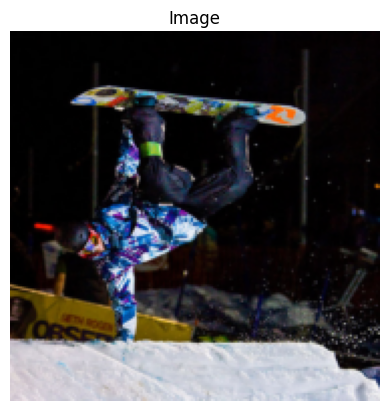

Input Caption: <START> snowboarder doing onehanded <UNK> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: snowboarder doing onehanded <UNK> <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [28]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the corresponding caption inputs and targets
    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Example usage:
print("Training example:")
visualize_example(train_captions, train_input_sequences, train_target_sequences)

print("Validation example:")
visualize_example(val_captions, val_input_sequences, val_target_sequences)


In [29]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(ResBlockMLP, self).__init__()
        
        # Define layer normalization for input size
        self.norm1 = nn.LayerNorm(input_size)
        
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        # Layer normalization for input size // 2
        self.norm2 = nn.LayerNorm(input_size//2)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        # Final fully connected layer
        self.fc3 = nn.Linear(input_size, output_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        
        # Apply layer normalization and activation function
        x = self.act(self.norm1(x))
        
        # Calculate skip connection
        skip = self.fc3(x)
        
        # Apply layer normalization, fully connected layer, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        # Add skip connection
        return x + skip

In [30]:
class ConvNet(nn.Module):
    def __init__(self, channels_in, dropout):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(channels_in, out_channels = 16, padding = 1, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, out_channels = 32, padding = 1, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, out_channels = 64, padding = 1, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(dropout)

        self.act = nn.ReLU()
        
        self.linear = nn.Linear(33856, 4096)
    
    def forward(self, inputs): # (224, 224, 3)
        
        out = self.maxpool(self.dropout(self.bn1(self.act(self.conv1(inputs))))) # (112, 112, 32)
        
        out = self.maxpool(self.dropout(self.bn2(self.act(self.conv2(out))))) # (56, 56, 64)
        
        out = self.maxpool(self.dropout(self.bn3(self.act(self.conv3(out))))) # (28, 28, 128)
        
        out = out.flatten(start_dim = 1)

        return self.linear(out) # (B, 4096)
        

In [31]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, emb_size, hidden_size, num_layers, num_blocks):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(channels_in = 3, dropout = dropout)

        self.linear = nn.Linear(4096, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, bias = False, batch_first = True)

        # Residual blocks
        self.blocks = nn.Sequential(*[ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)])

        # Activation function
        self.act = nn.ELU()
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    # Memory in will always be a matrice of zeros
    def forward(self, images, captions, mem_in):

        features = self.convnet(images) # (B, 4096)
        features = self.linear(features) # (B, hidden_size)
        features = features.unsqueeze(0) # (1, B, hidden_size)

        batch_size = images.size(0)
        hidden_size = self.lstm.hidden_size
        num_layers = self.lstm.num_layers

        captions = self.embedding(captions)
        
        outputs, (hidden_out, mem_out) = self.lstm(captions, (features, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

        outputs = self.act(self.blocks(outputs))
        
        return self.fc_out(outputs) 

In [32]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

num_iterations = 1000

hidden_size = 256

learning_rate = 1e-5

channels_in = 3

dropout = 0.2

vocab_size = len(stoi)

emb_size = 128

hidden_size = 256

# LSTM layers
num_layers = 1

# ResBlocks
num_blocks = 1

batch_size = 4

max_length = max_length

# Paddding 1 less, than the max_length
time_steps = max_length - 1

In [33]:
model = Decoder(channels_in = channels_in, dropout = dropout, vocab_size = vocab_size, emb_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, num_blocks = num_blocks).to(device)

memory = torch.zeros(num_layers, batch_size, hidden_size, device=device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

training_loss = []

val_loss = []

In [34]:
# Let's see how many Parameters our model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters, %d Million" % (num_model_params, num_model_params//1e6 ) )

This model Has 141595618 Parameters, 141 Million


In [35]:
for iteration in range(num_iterations):

    # Training
    model.train()

    image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)

    image_batch = image_batch.to(device)
    caption_batch = caption_batch.to(device)
    label_batch = label_batch.to(device)
    
    outputs = model(image_batch, caption_batch, memory)
    
    outputs = outputs.reshape(batch_size * time_steps, -1)

    label_batch = label_batch.reshape(batch_size * time_steps)

    loss = loss_fn(outputs, label_batch)

    training_loss.append(loss.item())

    if iteration % 30 == 0: 
        print("iteration", iteration, "training loss:", loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Evaluate every so often
    if iteration % 30 == 0:
        
        model.eval()

        image_batch, caption_batch, label_batch = create_batch(val_captions, val_input_sequences, val_target_sequences, batch_size)
    
        image_batch = image_batch.to(device)
        caption_batch = caption_batch.to(device)
        label_batch = label_batch.to(device)
        
        outputs = model(image_batch, caption_batch, memory)
        
        outputs = outputs.reshape(batch_size * time_steps, -1)
    
        label_batch = label_batch.reshape(batch_size * time_steps)
    
        loss = loss_fn(outputs, label_batch)

        val_loss.append(loss.item())
        
        print("iteration", iteration, "val loss:", loss.item())
    
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

iteration 0 training loss: 8.05785083770752
iteration 0 val loss: 8.021525382995605
iteration 30 training loss: 7.162975311279297
iteration 30 val loss: 7.213709831237793
iteration 60 training loss: 6.379136562347412
iteration 60 val loss: 6.456013202667236
iteration 90 training loss: 6.031409740447998
iteration 90 val loss: 6.091487407684326
iteration 120 training loss: 4.884740829467773
iteration 120 val loss: 4.492790222167969
iteration 150 training loss: 5.089856147766113
iteration 150 val loss: 3.906050205230713
iteration 180 training loss: 4.001670837402344
iteration 180 val loss: 4.578573703765869
iteration 210 training loss: 3.1417133808135986
iteration 210 val loss: 3.736956834793091
iteration 240 training loss: 3.400916814804077
iteration 240 val loss: 4.031529903411865
iteration 270 training loss: 2.776301622390747
iteration 270 val loss: 2.585259199142456
iteration 300 training loss: 1.702991247177124
iteration 300 val loss: 2.8366267681121826
iteration 330 training loss: 3

KeyboardInterrupt: 

Text(0.5, 1.0, 'Training loss')

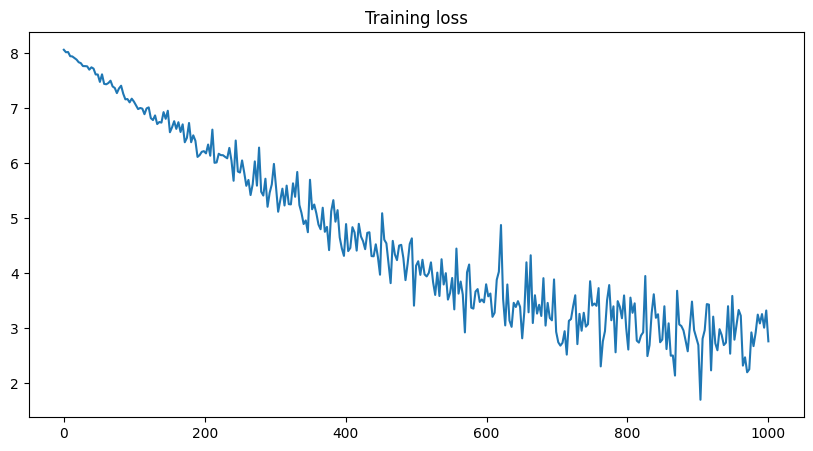

In [51]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(training_loss))
plt.plot(train_x, training_loss)
plt.title("Training loss")

Text(0.5, 1.0, 'Val loss')

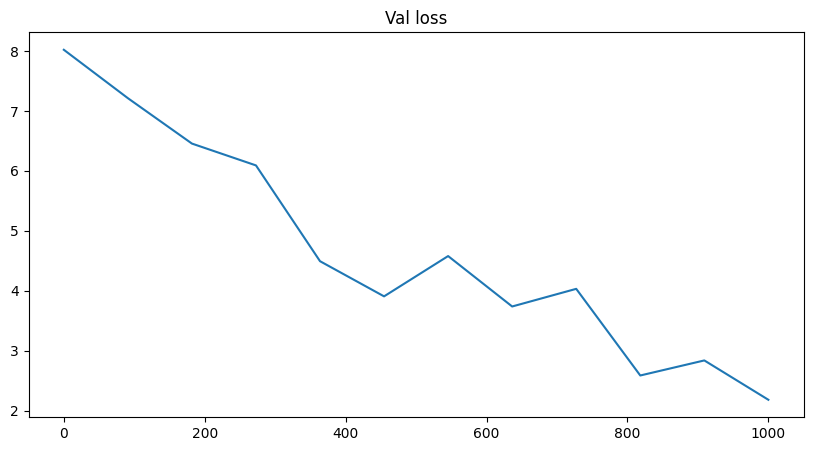

In [53]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_iterations, len(val_loss))
plt.plot(train_x, val_loss)
plt.title("Val loss")

In [54]:
max_length = 30

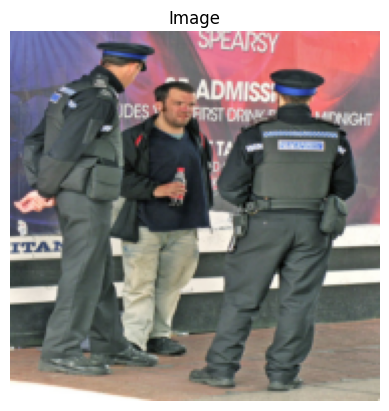

Original Caption: <START> two policemen are talking to man who is holding bottle <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: fluffy with appears cameras shots touch star slides card crowds overhang very poodle laptop paying bushes teacher jumpsuit wooded army dirt barks stools castle trots hockey drums checked stairs gathering
Generated Caption: twilight sponge kayak fake romp stores alert theme pooh traverses igloo post foreground canoe chains multicolor launch reflection coach polo telescope overhead stretched worn stump paint cigar underneath her legs
Generated Caption: four laughs official event corn heavy model profile give center fresh splashing traverses bedroom stare nine aid gym handstand maneuver local swoops splits priest footprints wooded travels siting stack wheels
Generated Caption: by punches dried get stair sized highway raising stool pail cafe shirt shining cushio

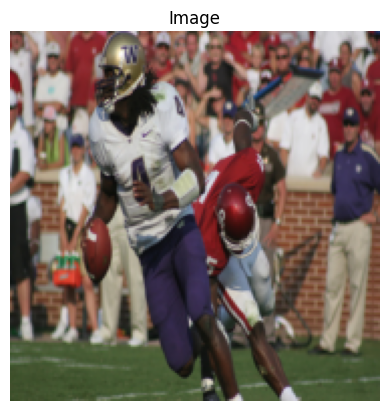

Original Caption: <START> football player in red is trying to tackle another player who has the ball <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: riders distant country bows uniform the ponytail blond wicker tent friends its green skips compete dolphins very pajama wakeboard mouths wakeboarder ruins natural colored natural blocks fall uphill just equestrian
Generated Caption: starring instructor rushing surfer climbers drag reached tightrope cellphones well rocket paraglider overlooking costumes canal protesters coming sacks beer howling image bottle lack officer volleyball carried landscape eats guitars border
Generated Caption: obama wooden box scenic swimmer points showing car pond tall snowball winnie rowing rifle stands pulled dreadlocks tires abandoned artwork bridal eye empty <UNK> multicolor bread paw toilets einstein printed
Generated Caption: before kick strings binoculars kayaks rifle jeep conv

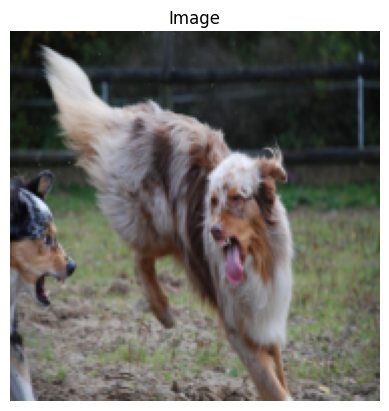

Original Caption: <START> two furry dogs make <UNK> faces as they play together <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: boats collar sleeved jog whom interacting disc figures bow scenic challenging curved swampy desk bottle torn identical huddle hovers learning irish pair ties waiter ear person oar truck feild alert
Generated Caption: view in pull parents lady listens tshirt medium leap bat stuffed camo starting trip her photograph training product helmets beers stepping seagull stone holding cigarette doing heels handbag flip home
Generated Caption: garage bares cuts member clowns hardhat try bushes chess pumpkins doorway button beautiful squirts backwards nurses covers sound mountainside baseman lane electric protective floaties power parked stuck atop pass classroom
Generated Caption: leashes union laptops boston fashioned serving bundled dalmation itself horizontal exercis

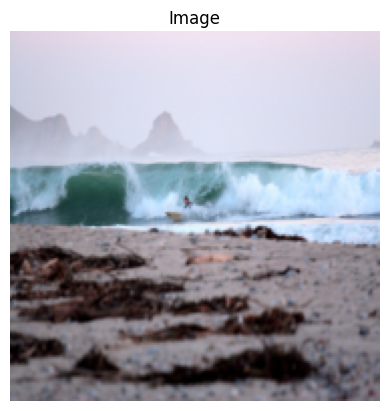

Original Caption: <START> surfer is caught in an incoming wave along dirty beach nearby mountains <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: tumbling apartment burn stairway cover elder dyed running self offroad swung ad sale checks dry quarterback pirate geese money wrapping side crosscountry cheek floating village map religious wintry self sporting
Generated Caption: tag logo pedestrians bodies sells padded singing sails bee wrestle polka chat boarder unknown ball parent airborne michael armenian flannel big lit individual cushion spotlight tongue hallway blacktop gestures pattern
Generated Caption: listens pitcher long university leashes cream carpeted teaches stretched military sniffing fireman chased model plushie lady drinking smartly touching attacking canyon pauses cold umbrella arched ride trying shakes lens lack
Generated Caption: practices carpeted nose seeds barely new sleeves mo

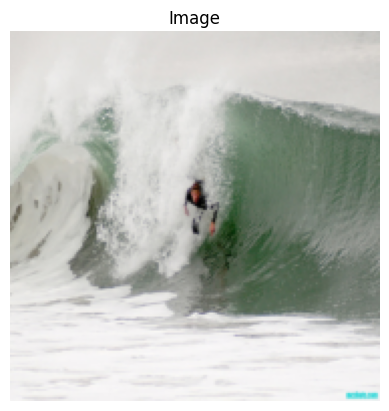

Original Caption: <START> surfer is in the middle of huge wave <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Generated Caption: woven calm marketplace sequined milkshake reception scooters viewer tulips embraces friends tags offroad against smoke stoop evil shaking skatepark rest earth fall popsicle stream dot conversations perform leash using working
Generated Caption: plaza <PAD>
Generated Caption: practicing mesh digging club piano turn teal offering smelling executes canoes skies tables leashes footballers cameras boa marked round robes hilly martial travels wire swans kangaroo playground messy advertisement staring
Generated Caption: boxers object sponsored tattoo clothed officer engine hardhat army bark piggy different waiting point net wakeboarder stripy protesters jogger part tall cheeks love just dogs cargo icy flower clean peers
Generated Caption: grassy repelling sea cycling pos

In [56]:
def sample_caption(image, max_length=30):

    model.eval()
    
    # Initialize the <sos> token
    sos_token = torch.tensor([[stoi['<START>']]], device=device)
    
    features = model.convnet(image.unsqueeze(0).to(device))  # Get features from the image
    features = model.linear(features)  # Transform features to hidden size
    features = features.unsqueeze(0)  # Add time dimension (1, 1, hidden_size)
    
    input_tokens = sos_token  # Start with <sos> token
    generated_caption = []
    
    for _ in range(max_length):
        input_embed = model.embedding(input_tokens)  # Embed the input tokens
        
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        output, _ = model.lstm(input_embed, (features, torch.zeros_like(features)))
        
        output = model.blocks(output)
        
        output = model.fc_out(output)  # Output shape: (1, seq_length, vocab_size)
        
        # Softmax across the last layer and sample from the distribution of vocabularies at the last time step
        probabilities = F.softmax(output[:, -1, :], dim=-1)
        
        next_token = torch.multinomial(probabilities, num_samples=1)
        
        # Append the generated token to the caption
        generated_caption.append(itos[next_token.item()])
        
        # Concatenate the current input token with previously generated tokens
        input_tokens = torch.cat([input_tokens, next_token], dim=1)

        # If <eos> token is generated or <pad> token (assumed stoi['<pad>'] == 0), stop
        if next_token.item() == stoi['<END>'] or next_token.item() == stoi['<PAD>']:
            break
    
    return generated_caption


def visualize_example(caption_dict, input_seq_dict, target_seq_dict, max_length=30):
    
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Display the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the original caption
    original_caption_encoded = input_seq_dict[random_image][caption_idx]
    original_caption = decode_caption(original_caption_encoded)
    print(f"Original Caption: {original_caption}")

    for _ in range(5):
        # Generate a caption using the model
        generated_caption = sample_caption(image_tensor, max_length)
        
        # Print the generated caption
        print(f"Generated Caption: {' '.join(generated_caption)}")

# Example usage:
num_samples = 5
for _ in range (num_samples):
    visualize_example(val_captions, val_input_sequences, val_target_sequences, max_length = max_length)
